# DEA CoastLines validation

To do:
* [ ] Change output CRS to Australian Albers
* [ ] Discard validation sides with multiple intersects?

In [ ]:
# import xarray as xr
# from shapely.geometry import Point, LineString


## Load modules/functions


In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box

sys.path.append('/g/data/r78/rt1527/dea-notebooks/MAHTS/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df, fname='test.shp', x='x', y='y', crs='EPSG:3577'):
    
    # Convert datetimes to strings
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_file(fname)

## Analysis
To investigate:
* [ ] Outlier in Bermagui (Horseshoe Bay)
* [ ] Multiple outliers in Boambee Beach
* [ ] Single remaining outlier in Bogangar to Kingscliff
* [ ] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [ ] Sporadic outliers in Byron Bay
* [ ] Two remaining outlier in Corindi Beach
* [ ] **Major outliers at Crowdy Head**
* [ ] **String of outliers in opposite direction at Cullendulla**
* [ ] One remaining outlier at Diamond Beach
* [ ] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [ ] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [ ] **Remaining major outlier at Lake Illawarra**
* [ ] **Outliers in Manly Beach**
* [ ] Outliers at Mooney Beach
* [ ] **Major issues with offset shorelines at Narrabeen/Collory**
* [ ] **Outliers in opposite direction at Park's Beach**
* [ ] Cluster of outliers at Patch's Beach
* [ ] Port Hacking currently excluded from DEACL by estuary mask
* [ ] **Weird line of points at Rainbow Beach**
* [ ] **No relationship at Sandbar Beach**
* [ ] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [ ] **Cluster of outliers at The Entrance**
* [ ] Single outlier at Warrain

,id,rmse,mae,r2,cor
0,wadot_munglinuppoint ...,18.198816,16.985112,0.742031,0.983229
1,wadot_entrancepointe ...,24.111092,16.978924,0.734674,0.908244
2,wadot_swanbourne ...,14.048627,11.764892,0.546336,0.910011
3,wadot_sandypoint ...,10.045728,8.060522,0.973238,0.992533
4,wadot_wyliehead ...,17.719276,14.673315,0.611514,0.920711


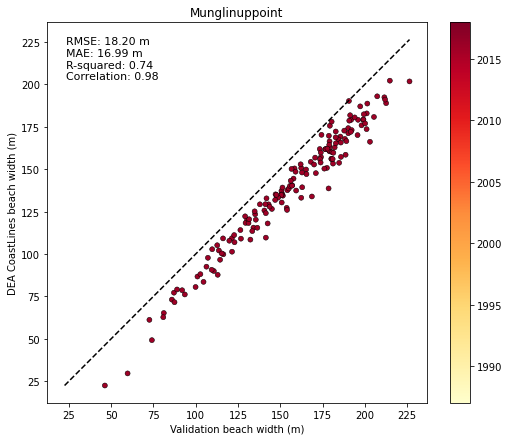

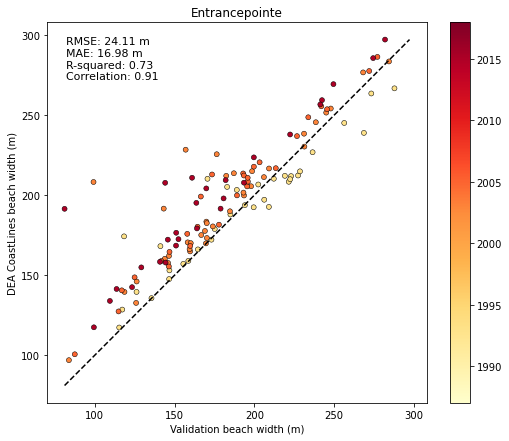

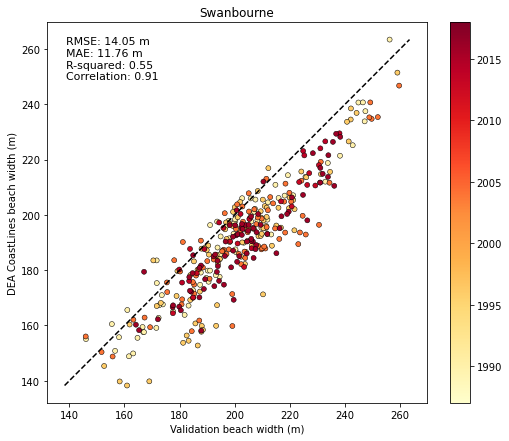

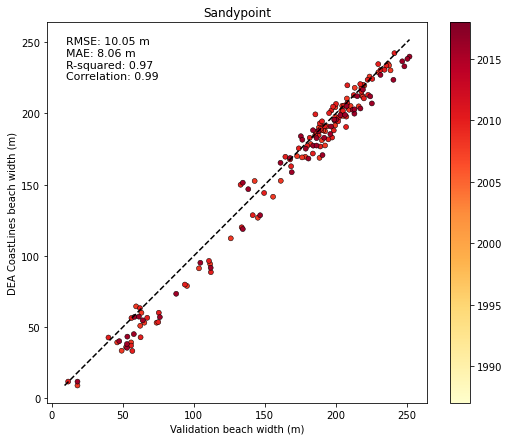

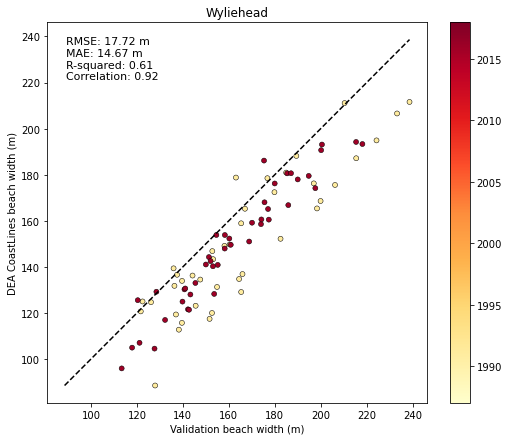

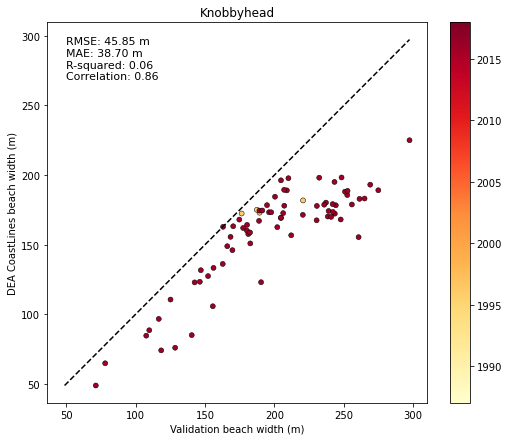

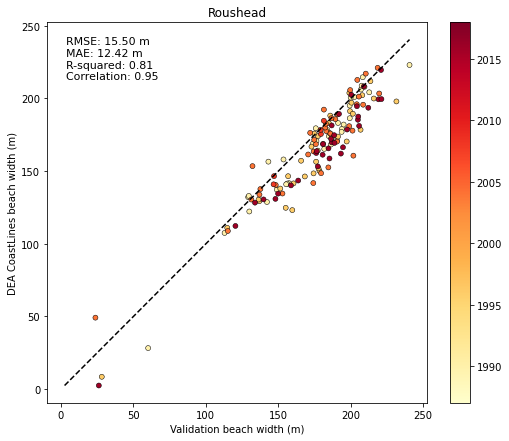

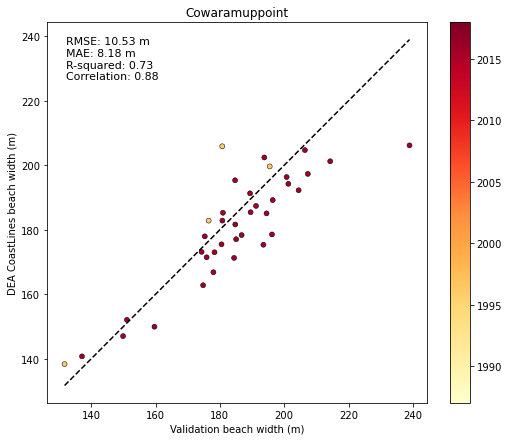

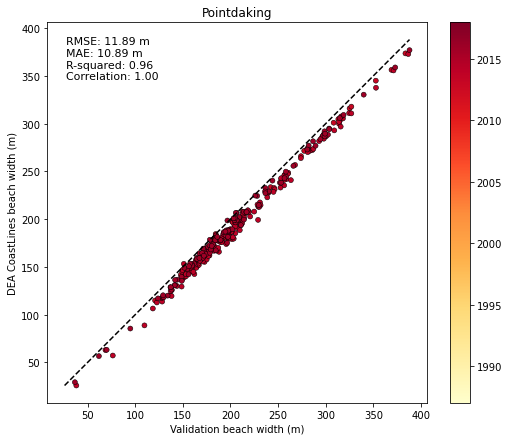

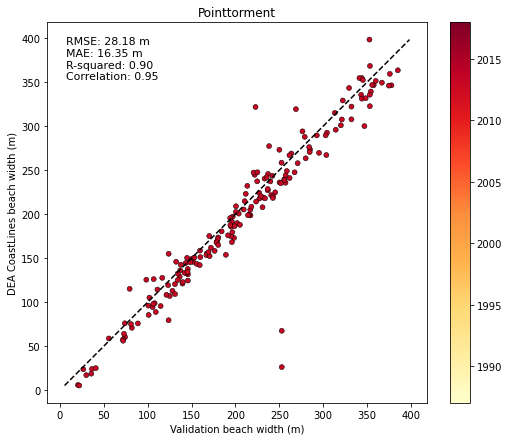

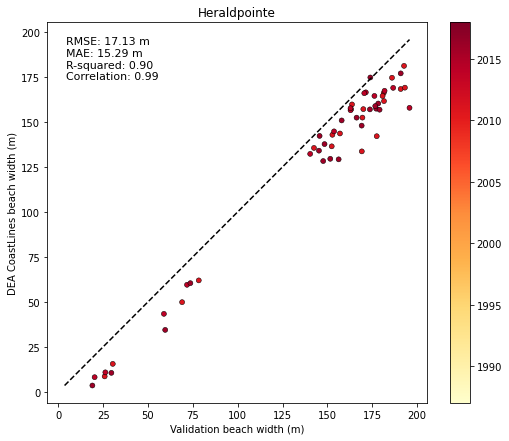

In [238]:
val_paths = glob.glob('output_data/wadot*.csv')
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'
# deacl_path = '../DEACoastLines_coastlines_v0.2.0_0.20.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0,
                                              sat_offset=0, 
                                              return_df=False,
                                              eval_shapes=True)
    # Close figure if plotting over 10
    if len(stats_list) > 10: plt.close()
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.DataFrame([stats for stats in stats_list if stats])
stats_df.head()


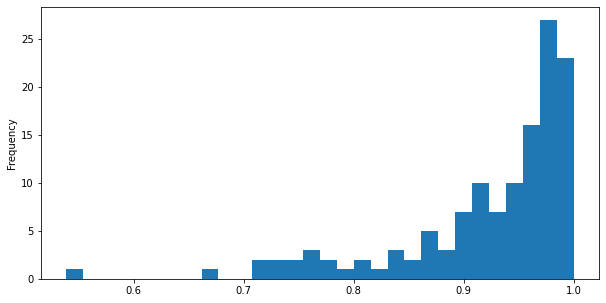

In [239]:
stats_df['cor'].plot.hist(bins=30, figsize=(10, 5))  #, range=(0, 100))

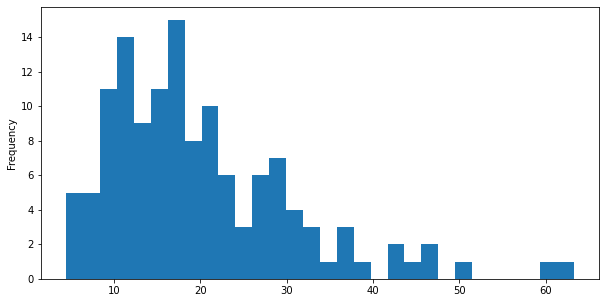

In [240]:
stats_df['rmse'].plot.hist(bins=30, figsize=(10, 5))  #, range=(0, 100))

In [241]:
stats_df['rmse'].median()

17.44511788120862

In [244]:
stats_df['mae'].median()

14.13196118156982

## Pre-processing


### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [ ]:
for fname in glob.glob('input_data/nswbpd/*Stockton*.csv'):
    profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                              datum=0, 
                                              overwrite=True)     


### City of Gold Coast
* [X] Renovated

In [ ]:
# List of sites to iterate over
all_profiles = glob.glob(f'input_data/cityofgoldcoast/*.txt')
sites = np.unique([i.split(' - ')[0].split('/')[-1] for i in all_profiles])
sites = ['SOUTH STRADBROKE']

for site in sites:
    deacl_val.preprocess_cgc(site=site, 
                             datum=0,
                             overwrite=True)

### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]

for site in sites[3:4]:
    deacl_val.preprocess_tasmarc(site, overwrite=True) 


### WA DoT
* [X] Renovated

In [246]:
# Read in tertiary compartment file to regionalise results
tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')
tertiary_gdf = tertiary_gdf.set_index('FROM_')

# Extract transects and validation distances
deacl_val.preprocess_wadot(regions_gdf=tertiary_gdf, 
                           fname='input_data/wadot/Coastline_Movements_20190819.gdb',
                           smartline='../input_data/Smartline.gdb',
                           aus_poly='/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

## Testing NSWBPD

In [ ]:
fname = 'input_data/nswbpd/photogrammetry_Xsections_Burril Lake and Racecourse Beach.csv'

# Get output filename
name = Path(fname).stem.split('_')[-1].lower().replace(' ', '')
fname_out = f'output_data/nswbpd_{name}.csv'

# Read in data
print(f'Processing {fname_out}             ', end='\r')            
profiles_df = pd.read_csv(fname, skiprows=5)
profiles_df['Year/Date'] = pd.to_datetime(profiles_df['Year/Date'],
                                          dayfirst=True,
                                          errors='coerce')

# Restrict to post 1987
profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

# Convert columns to strings and add unique ID column
profiles_df['Beach'] = profiles_df['Beach'].str.lower().str.replace(' ', '')
profiles_df['Block'] = profiles_df['Block'].astype(str).str.lower()
profiles_df['Profile'] = profiles_df['Profile'].astype(str).str.lower()
profiles_df['site'] = profiles_df[['Beach', 'Block',
                                   'Profile']].apply('_'.join, 1)

# Rename columns
profiles_df.columns = ['beach', 'section', 'profile', 'date', 'chainage', 
                       'elevation', 'easting', 'northing', 'source', 'site']

# # Compute origin points for each profile
# start_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmin(), 
#                             ['site', 'easting', 'northing']]
# start_xy = start_xy.rename({'easting': 'start_x', 
#                             'northing': 'start_y'}, axis=1)
# start_xy = start_xy.reset_index(drop=True)

# # Compute end points for each profile
# end_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmax(), 
#                          ['site', 'easting', 'northing']]
# end_xy = end_xy.rename({'easting': 'end_x', 
#                         'northing': 'end_y'}, axis=1)
# end_xy = end_xy.reset_index(drop=True)

# # Join origin and end points into dataframe
# profiles_df = pd.merge(left=profiles_df, right=start_xy)
# profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='easting', 
#                                                   y_col='northing', 
#                                                   z_col='elevation', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_sub = profiles_df[(profiles_df.site == 'burrillakeandracecoursebeach_1_5') & (profiles_df.date == '1993-05-14') ]  

In [ ]:
burrillakeandracecoursebeach_1_5

In [ ]:
to_vector(profiles_df, x='easting', y='northing', fname='test6.shp')

## Testing GCC

In [ ]:
results_df


results_df[(results_df.site == 'broadbeach_eta_59') ]

In [ ]:
pd.read_csv(val_paths[0], parse_dates=['date'], index_col='site').loc['broadbeach_eta_58.50']

In [ ]:
 x.geometry_val.intersection(x.geometry_deacl)
            .hausdorff_distance(Point(x.start_x, x.start_y)), axis=1)


In [ ]:
gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val).plot()


gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.interpolate(219)).plot(ax=plt.gca())

In [ ]:
results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.length

In [ ]:
profile_i = '/g/data/r78/rt1527/dea-notebooks/MAHTS/validation/input_data/cityofgoldcoast/BROADBEACH - ETA 59 - (13474) 1996-06-05.txt'


pd.read_csv(profile_i,
                                 usecols=[1, 2, 3],
                                 delim_whitespace=True, 
                                 names=['x', 'y', 'z']).plot.scatter(x='x', y='z')

In [ ]:
profile_list 

In [ ]:
profile_list = glob.glob(f'input_data/cityofgoldcoast/SOUTH STRADBROKE - SSI 09 *.txt')

# Output list to hold data
site_profiles = []

for profile_i in profile_list:

    # Identify unique field values from file string
    profile_string = os.path.basename(profile_i)

    # Treat data file string differently depending on format
    if len(profile_string.split(' - ')) > 3:
        beach, section, profile, id_date = profile_string.split(' - ')            

    else:
        beach, section_profile, id_date = profile_string.split(' - ')

        if len(section_profile.split(' ')) == 2:
            section, profile = section_profile.split(' ')

        else:
            section, profile = 'none', section_profile

    # If beach name is in the list of problematic names, replace
    beach = manual_rename[beach] if beach in manual_rename.keys() else beach

    # Remove any special characters from beach/section/profile names and create ID 
    profile_df = pd.read_csv(profile_i,
                             usecols=[1, 2, 3],
                             delim_whitespace=True, 
                             names=['x', 'y', 'z'])
    profile_df['date'] = pd.to_datetime(id_date[-14:-4]) 
    profile_df['source'] = 'hydrographic survey'
    profile_df['profile'] = profile.lower()
    profile_df['section'] = section.lower()
    profile_df['beach'] = beach.replace(' ', '').lower()
    profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)

    # Filter to drop pre-1987 and deep water samples, add to list if any 
    # data is available above 0 MSL
    profile_df = profile_df[profile_df.z > -3.0]
    profile_df = profile_df[profile_df.date > '1987']    
    if profile_df.z.max() > 0:
        site_profiles.append(profile_df)

# Combine into a single dataframe
profiles_df = pd.concat(site_profiles)

# Compute origin and end points for each profile
start_xy = profiles_df.groupby(['site'], as_index=False).first()[['site', 'x', 'y']]
end_xy = profiles_df.groupby(['site'], as_index=False).last()[['site', 'x', 'y']]
start_xy = start_xy.rename({'x': 'start_x', 'y': 'start_y'}, axis=1)
end_xy = end_xy.rename({'x': 'end_x', 'y': 'end_y'}, axis=1)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=start_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Compute chainage
# profiles_df['chainage'] = profiles_df.apply(
#     lambda x: math.hypot(x.x - x.start_x, x.y - x.start_y), axis = 1)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='x', 
#                                                   y_col='y', 
#                                                   z_col='z', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_subset = profiles_df.loc[profiles_df.date.dt.year == 2013]
profiles_subset.plot(x='x', y='z')

In [ ]:
to_vector(profiles_df.loc[profiles_df.date.dt.year == 2013], fname='test4.shp')



    

In [ ]:
merge_test.groupby('year').median().reset_index().plot(x='year', y='DEA CoastLines beach width (m)')
merge_test.groupby('year').median().reset_index().plot(x='year', y='Validation beach width (m)', ax=plt.gca())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020